# Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Defining paths to input images

In [2]:
# Define paths to content and style images
content_image_path = '/kaggle/input/content-and-style-images/content-images/lion.jpg'
style_image_path = '/kaggle/input/content-and-style-images/style-images/udnie.jpg'

# Image Pre-processing

## **Why Pre-process the Images?**

1.  **Consistency with Pre-trained Models**: VGG19, the model we're using, was trained on images that were preprocessed in a specific way. To ensure the model interprets our images correctly, we need to pre-process them the same way.
2.  **Standardization**: Pre-processing transforms raw image data into a format the model can process (e.g., resizing, normalizing pixel values).
3.  **Batch Dimension**: Deep learning models typically expect input as batches of data, so even for a single image, we add an extra dimension to mimic a batch.

## **How Pre-processing Works**

1.  **Resizing**: Resizes the input images to a standard size (e.g., 400x400 pixels) for consistency.
2.  **Conversion**: Converts the image to a numerical array that TensorFlow can process.
3.  **Batch Dimension**: Adds an extra dimension to the image array to simulate a batch.
4.  **Normalization**: Applies transformations specific to VGG19, such as subtracting the mean RGB values (`[103.939, 116.779, 123.68]`) and reordering the color channels from RGB to BGR.

## Code to Pre-Process Image

In [3]:
# function to preprocess an image

def preprocess_image(image_path, target_size=(400, 400)):
    
    img = load_img(image_path, target_size=target_size)  # Resize image
    img_array = img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = vgg19.preprocess_input(img_array)  # Preprocess for VGG19
    return img_array

# Preprocess content and style images
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)

In [4]:
print("Content Image Shape:", content_image.shape)
print("Content Image[0] Shape:", content_image[0].shape)

print()

print("Style Image Shape:", style_image.shape)
print("Style Image[0] Shape:", style_image[0].shape)

Content Image Shape: (1, 400, 400, 3)
Content Image[0] Shape: (400, 400, 3)

Style Image Shape: (1, 400, 400, 3)
Style Image[0] Shape: (400, 400, 3)


# Image visualisation and De-Processing

## **Why De-Process the Images?**

Since the images are preprocessed for the VGG19 model (with mean pixel values subtracted and channels reordered), we'll need to **deprocess** them to display them in a human-readable form.

Deprocessing involves:

1.  Adding back the mean pixel values (`[103.939, 116.779, 123.68]`) to restore the original pixel range.
2.  Converting the channels from BGR (used by VGG19) back to RGB.

## Code to De-Process Image

In [5]:
# function to deprocess an image

def deprocess_image(img_array):
    
    img_array = img_array.copy()
    
    # Remove the batch dimension if present
    if len(img_array.shape) == 4:
        img_array = img_array[0]
        
    # Add mean pixel values
    img_array[:, :, 0] += 103.939
    img_array[:, :, 1] += 116.779
    img_array[:, :, 2] += 123.68
    
    # Convert from BGR to RGB
    img_array = img_array[:, :, ::-1]
    
    # Clip pixel values
    img_array = np.clip(img_array, 0, 255).astype('uint8')
    return img_array


## Code to visualise Image

Content Image:



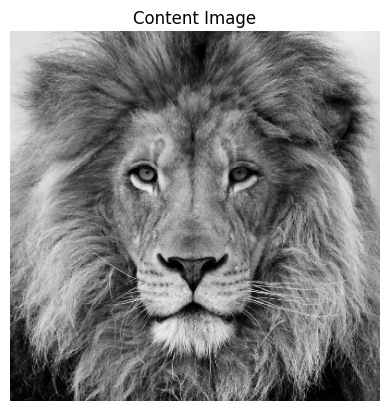


Style Image:



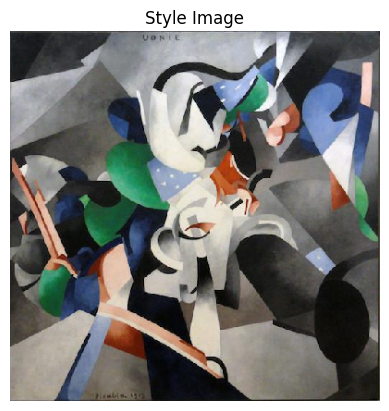

In [6]:
# function to display images

def display_image(img_array, title="Image"):
    
    img = deprocess_image(img_array)
    plt.imshow(img)
    plt.title(title)
    print()
    plt.axis('off')
    plt.show()
    print()

# Display the content and style images
print("Content Image:")
display_image(content_image[0], title="Content Image")


print("Style Image:")
display_image(style_image[0], title="Style Image")

# Image Feature Extraction

## **Why Extract Features?**

The VGG19 model is a deep convolutional network that has been trained on millions of images. Its layers capture different levels of abstraction:

-   **Lower layers**: Capture edges, textures, and simple patterns.
-   **Higher layers**: Capture shapes, structures, and complex patterns.

### For Neural Style Transfer:

1.  **Content Features**: Use deeper layers to capture the structure of the content image.
2.  **Style Features**: Use multiple layers to capture textures and patterns from the style image.

## **What We Need to Do**

1.  Load the pre-trained VGG19 model from `tensorflow.keras.applications`.
2.  Select specific layers for content and style extraction:
    -   **Content Layer**: `block5_conv2` (captures high-level structure).
    -   **Style Layers**: `[block1_conv1, block2_conv1, block3_conv1, block4_conv1, block5_conv1]` (capture patterns and textures at multiple scales).
3.  Modify the model to output these specific layers.

## Code for Model Creation

In [7]:
# Load the VGG19 model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Content layer to extract high-level structure
content_layer = 'block5_conv2'

# Style layers to capture patterns and textures
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Combine the layers
all_layers = style_layers + [content_layer]

# Load the VGG19 model pre-trained on ImageNet.
# The top layer responsible for classification is not included in the model.
vgg = VGG19(weights='imagenet', include_top=False)

# Create a model that outputs the selected layers
outputs = [vgg.get_layer(name).output for name in all_layers]
feature_extraction_model = Model(inputs=vgg.input, outputs=outputs)

# Freeze the model weights so that they do not change during training.
for layer in feature_extraction_model.layers:
    layer.trainable = False

print("VGG19 model loaded and modified for feature extraction.")


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
VGG19 model loaded and modified for feature extraction.


## Code for Feature Extraction

##### Explanation of the Code

1.  Imports: The code begins by importing the TensorFlow library, which is essential for building and running the model.
2.  Function Definition: The `extract_features` function is defined with three parameters: `model`, `content_image`, and `style_image`.
3.  Combining Images: The content and style images are concatenated along the batch dimension, allowing the model to process them simultaneously.
4.  Model Inference: The combined images are fed into the model, which outputs the features from the specified layers.
5.  Feature Separation: The outputs are divided into style and content features based on the predefined layer structure.
6.  Feature Conversion: The features are converted from TensorFlow tensors to NumPy arrays for easier manipulation and analysis.
7.  Return Statement: Finally, the function returns the extracted content and style features.

In [8]:
def extract_features(model, content_image, style_image):
    
    # Combine content and style images into a single batch
    inputs = tf.concat([content_image, style_image], axis=0)
    
    # Pass the inputs through the model
    outputs = model(inputs)
    
    # Split the outputs back into content and style features based on the predefined layer structure.
    style_outputs = outputs[:len(style_layers)]
    content_output = outputs[len(style_layers):][0]
    
    # # Extract features
    # style_features = [layer.numpy() for layer in style_outputs]
    # content_features = content_output.numpy()

    # Extract features (no need for `.numpy()`; tensors are processed directly)
    style_features = [tf.convert_to_tensor(layer) for layer in style_outputs]
    content_features = tf.convert_to_tensor(content_output)
    
    return content_features, style_features

#  Invoking Extract features functions
content_features, style_features = extract_features(
    model=feature_extraction_model,
    content_image=content_image,
    style_image=style_image
)

print("Content and style features extracted successfully!")


Content and style features extracted successfully!


# Computing Style Loss

## **Why compute Style Loss?**

The **style loss** measures how well the generated image captures the patterns and textures of the style image. It compares the **Gram matrices** of the style image and the generated image.

## **Steps to compute Style Loss**

1.  Compute the Gram matrix for each style layer of the **style image** and **generated image**.
2.  Calculate the mean squared difference between these Gram matrices for all style layers.
3.  Weight the losses from each layer and sum them to get the total style loss.

## Code to compute Style Loss

In [9]:
def gram_matrix(features):
    
    # Flatten spatial dimensions (H, W) into a single dimension
    features = tf.reshape(features, (-1, features.shape[-1]))
    
    # Compute the Gram matrix
    gram = tf.matmul(features, features, transpose_a=True)
    return gram

def compute_style_loss(style_features, generated_features):
    
    style_loss = 0
    weight_per_layer = 1.0 / len(style_layers)  # Equal weighting for each layer
    
    for style_feature, generated_feature in zip(style_features, generated_features):
        
        # Compute the Gram matrix for both style and generated features
        style_gram = gram_matrix(style_feature)
        generated_gram = gram_matrix(generated_feature)
        
        # Compute the layer style loss
        layer_style_loss = tf.reduce_mean(tf.square(style_gram - generated_gram))
        
        # Add to the total style loss
        style_loss += weight_per_layer * layer_style_loss
    
    return style_loss

## Testing Style loss

In [10]:
# Simulate generated image's feature maps with random noise
generated_features = [tf.random.normal(shape=feature.shape) for feature in style_features]

# Compute the style loss between the style features and random generated features
style_loss = compute_style_loss(style_features, generated_features)

print(f"Style Loss (Test): {style_loss:.4f}")

Style Loss (Test): 1027175032662523904.0000


That's a massive number for the style loss! However, it makes sense because:

1.  The **Gram matrices** are being calculated from random noise (unrelated to the style image), so the difference is substantial.
2.  Style loss values tend to be large before optimization due to the untrained state of the generated image.

As we progress with the project and start optimizing the generated image, this value will decrease significantly.

# Computing Content Loss

The **content loss** ensures that the generated image preserves the structure and details of the content image. It compares the **content features** of the content image with the corresponding features of the generated image.

## **Steps to compute Content Loss**

1.  Extract the content features from the selected content layer for both:
    -   The content image (already done earlier).
    -   The generated image.
2.  Compute the mean squared error (MSE) between the two.

## Code to compute Content Loss

In [11]:
def compute_content_loss(content_features, generated_features):

    # Computing the Content Loss
    content_loss = tf.reduce_mean(tf.square(content_features - generated_features))

    # Return the value of computed Content Loss                              
    return content_loss

## Testing Content Loss

In [12]:
# Simulate generated image's content feature with random noise
generated_content_feature = tf.random.normal(shape=content_features[0].shape)

# Compute content loss
content_loss = compute_content_loss(content_features[0], generated_content_feature)

print(f"Content Loss (Test): {content_loss:.4f}")

Content Loss (Test): 2352.0132


# Computing Total Loss

## Total Loss combines
1. Style Loss
2. Content Loss

## **Weighted Combination**

We balance the influence of content and style losses by introducing weights:

-   Total Loss = (α × Content Loss) + (β × Style Loss)
    -   α: Weight for content loss (e.g. 1e3 or 1e4).
    -   β: Weight for style loss (e.g. 1.0).

## Code to compute Total Loss

In [13]:
# Function to compute Total Loss
def compute_total_loss(content_loss, style_loss, content_weight=1e3, style_weight=1.0):
    
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    return total_loss

## Testing Total Loss

In [14]:
# Define weights
content_weight = 1e3
style_weight = 1.0

# Compute total loss
total_loss = compute_total_loss(content_loss, style_loss, content_weight, style_weight)

print(f"Total Loss (Test): {total_loss:.4f}")


Total Loss (Test): 1027175032662523904.0000


That is an extremely large total loss value, and it stems from the massive **style loss**. This is expected because:

1.  The **random initialization** of the generated image causes a significant mismatch with the style image, leading to a high style loss.
2.  The content loss, while relatively smaller, is scaled by α=1e3\alpha = 1e3α=1e3, further contributing to the total loss.

# Optimisation

## **Optimizing the Generated Image**

To reduce this total loss, we need to:

1.  Define the **loss function** that combines content and style losses.
2.  Use a gradient-based optimization method to iteratively update the **generated image** so it minimizes the total loss.

## **Steps to Implement Optimization**

1.  **Set Up the Trainable Variable**:

    -   The generated image will be a **trainable variable**, initialized as random noise.
    -   We'll update this variable during the optimization process.
2.  **Define the Optimization Function**:

    -   Compute the content loss, style loss, and total loss for the generated image.
    -   Use TensorFlow's `GradientTape` to calculate gradients with respect to the generated image.
3.  **Update the Generated Image**:

    -   Apply the gradients to update the generated image and reduce the loss.

## Code for Optimization

In [15]:
# Define the trainable generated image
# generated_image = tf.Variable(tf.random.normal(content_image.shape), trainable=True)
# generated_image = tf.Variable(content_image)
# generated_image = tf.Variable(style_image)

def initialize_combined_image(content_image, style_image, alpha):
    if content_image.shape != style_image.shape:
        raise ValueError("Content and style images must have the same shape.")
    
    # Blend the content and style images
    combined_image = alpha * content_image + (1 - alpha) * style_image
    
    # Convert to a trainable variable
    combined_image = tf.Variable(combined_image, trainable=True)
    
    return combined_image

alpha = 0.8  # Content weight
generated_image = initialize_combined_image(content_image, style_image, alpha)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e1)

def compute_total_variation_loss(image):
    """
    Compute the total variation loss for an image.
    It penalizes abrupt changes between adjacent pixel values.
    """
    x_deltas = image[:, :-1, 1:, :] - image[:, :-1, :-1, :]
    y_deltas = image[:, 1:, :-1, :] - image[:, :-1, :-1, :]
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

@tf.function
def train_step(content_image, style_image, content_features, style_features, 
               content_weight=1e1, style_weight=6e5, tv_weight=1e-6):
    with tf.GradientTape() as tape:
        # Extract features from the generated image
        generated_content_features, generated_style_features = extract_features(
            model=feature_extraction_model, content_image=generated_image, style_image=generated_image
        )

        # Compute content loss
        gen_content_features = generated_content_features
        content_loss = compute_content_loss(content_features[0], gen_content_features[0])

        # Compute style loss
        gen_style_features = generated_style_features
        style_loss = compute_style_loss(style_features, gen_style_features)

        # Compute total variation loss
        tv_loss = compute_total_variation_loss(generated_image)

        # Compute total loss (content + style + TV loss)
        total_loss = (content_weight * content_loss + 
                      style_weight * style_loss + 
                      tv_weight * tv_loss)
    
    # Compute gradients
    gradients = tape.gradient(total_loss, generated_image)

    # Apply gradients
    optimizer.apply_gradients([(gradients, generated_image)])
    
    # Clip pixel values to ensure they remain valid
    generated_image.assign(tf.clip_by_value(generated_image, 0.0, 255.0))

    return total_loss, content_loss, style_loss, tv_loss



## Training the **Randomly** generated image

Epoch 0, Total Loss: 1.1404859851717665e+23, Content Loss: 682.207275390625, Style Loss: 1.9008099322953728e+17, TV Loss: 11095386.0



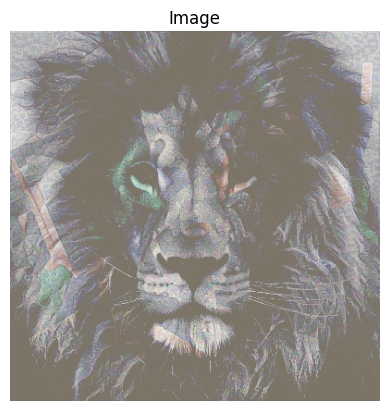


Epoch 100, Total Loss: 2.2869051476006196e+22, Content Loss: 3458.251220703125, Style Loss: 3.811508597293056e+16, TV Loss: 14260056.0



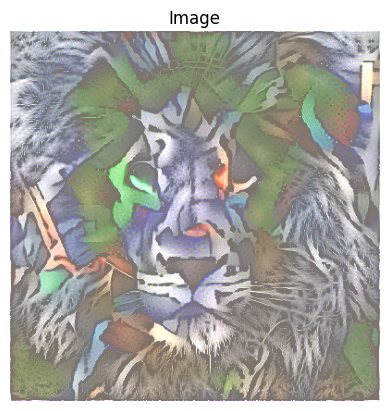


Epoch 200, Total Loss: 2.0954855001187523e+22, Content Loss: 3353.530517578125, Style Loss: 3.4924758495657984e+16, TV Loss: 16720822.0



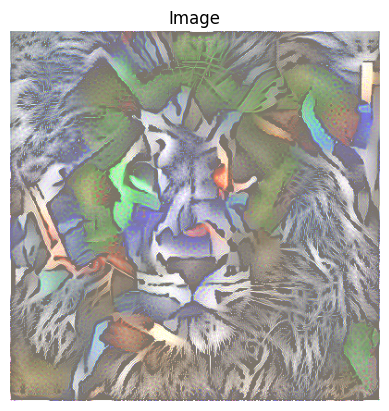


Epoch 300, Total Loss: 2.007987539938366e+22, Content Loss: 3333.7490234375, Style Loss: 3.346645818487603e+16, TV Loss: 18875124.0



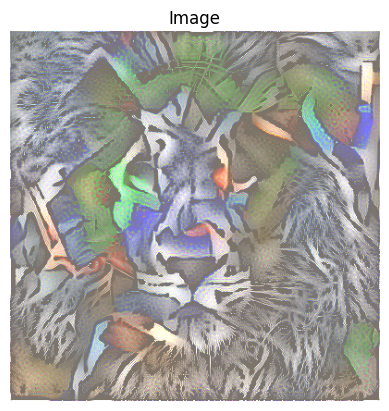


Epoch 400, Total Loss: 2.1767655654736095e+22, Content Loss: 3426.51806640625, Style Loss: 3.627942554055475e+16, TV Loss: 19409350.0



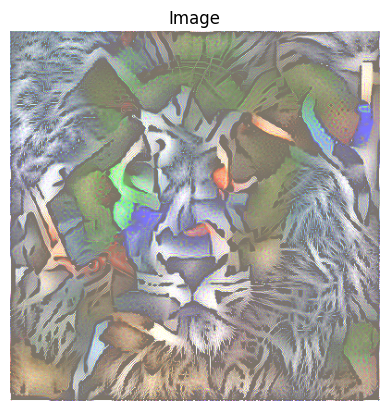


Epoch 500, Total Loss: 1.9169270072727482e+22, Content Loss: 3322.644287109375, Style Loss: 3.194878209871053e+16, TV Loss: 20992752.0



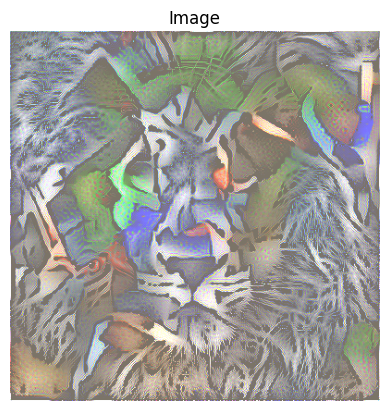


Epoch 600, Total Loss: 1.9036157178541293e+22, Content Loss: 3365.3125, Style Loss: 3.1726929858002944e+16, TV Loss: 22439806.0



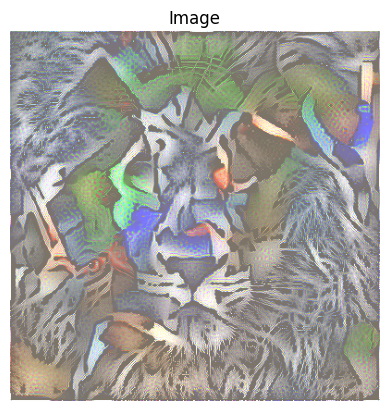


Epoch 700, Total Loss: 1.885495484753404e+22, Content Loss: 3348.66015625, Style Loss: 3.142492493761741e+16, TV Loss: 23638888.0



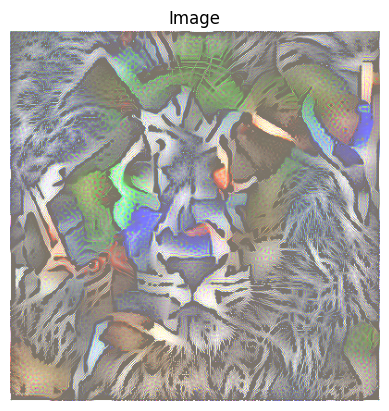


Epoch 800, Total Loss: 1.9237992751241342e+22, Content Loss: 3357.7294921875, Style Loss: 3.2063322434043904e+16, TV Loss: 24607102.0



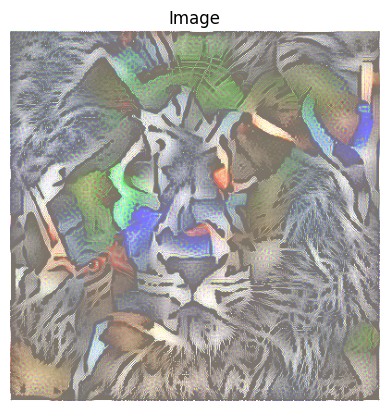


Epoch 900, Total Loss: 1.922781236428367e+22, Content Loss: 3276.229248046875, Style Loss: 3.2046355165741056e+16, TV Loss: 25791152.0



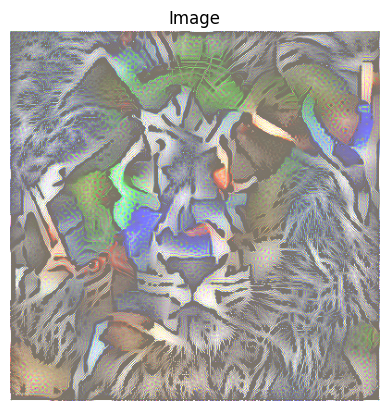

In [16]:
epochs = 1000

for epoch in range(epochs):
    total_loss, content_loss, style_loss, tv_loss = train_step(
        content_image, style_image, content_features, style_features
    )
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, Content Loss: {content_loss.numpy()}, Style Loss: {style_loss.numpy()}, TV Loss: {tv_loss.numpy()}")

        display_image(generated_image.numpy()[0])

# Enhancing Generated Image

In [17]:
import cv2

def enhance_generated_image(generated_image, scale_factor=2, brightness=50):
    
    # Preprocess: Ensure the image is 3D (H, W, C)
    if len(generated_image.shape) == 4:  # Remove batch dimension
        generated_image = tf.squeeze(generated_image, axis=0)
    elif len(generated_image.shape) == 2:  # Convert grayscale to RGB
        generated_image = tf.image.grayscale_to_rgb(tf.expand_dims(generated_image, axis=-1))
    
    # Convert to NumPy and ensure valid range
    image_array = np.clip(generated_image.numpy(), 0, 255).astype(np.uint8)
    
    # Check if the image is RGB
    if len(image_array.shape) != 3 or image_array.shape[2] != 3:
        raise ValueError("Input image must have shape (height, width, 3) for RGB.")
    
    # # Step 1: Sharpen the image
    # sharpening_kernel = np.array([[0, -1, 0],
    #                                [-1, 5, -1],
    #                                [0, -1, 0]])
    # sharpened_image = cv2.filter2D(image_array, -1, sharpening_kernel)

    # by passing the sharpening step as it was not looking great.
    sharpened_image = image_array
    
    # Step 2: Enhance resolution
    height, width, _ = sharpened_image.shape
    enhanced_resolution = cv2.resize(sharpened_image, (width * scale_factor, height * scale_factor), interpolation=cv2.INTER_CUBIC)
    
    # Step 3: Brighten the image
    # enhanced_image = cv2.convertScaleAbs(enhanced_resolution, alpha=1, beta=brightness)

    # by passing the brightening step as it was not looking great.
    enhanced_image = enhanced_resolution
    
    return enhanced_image


In [18]:
# Assume 'generated_image' is a tf.Variable
enhanced_image = enhance_generated_image(generated_image, scale_factor=5, brightness=50)

# Save or display the enhanced image
cv2.imwrite("enhanced_output.png", enhanced_image)

True